In [1]:
import tensorflow as tf
from utils import actomyosin_data, plot64
from model.autoencoder_3d_xy50_t8 import AE
from train_utils.autoencoder import AETrain, VAETrain, CVAETrain
import time
import argparse
from datetime import datetime
from packaging import version
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import tifffile
import os
import warnings
from itertools import cycle, islice

from skimage.transform import resize
from skimage.io import imsave, imread

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

2024-08-11 16:16:41.068311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# args
ae_type = 'AE'
net_type = 'simple'
latent_dim = 12
num_epochs = 1000
learn_rate = 0.001
train_buf = 12000
batch_size =900

In [3]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [4]:
import tensorboard
tensorboard.__version__

'2.12.1'

In [5]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-08-11 16:16:43.285199: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-08-11 16:16:43.285225: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-08-11 16:16:43.287013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-11 16:16:43.456878: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-08-11 16:16:43.457372: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2024-08-11 16:16:43.465131: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-08-11 16:16:43.465202: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [6]:
data_dir = '/mnt/d/lding/actomyosin/data/VidS1_TopCell/FlowFrame_50pix'
patch_size = 50
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))

    train_img = train_img - train_img.min()
    train_img = train_img/train_img.max()
    
    movie_len = train_img.shape[0]   
    small_train_img = resize(train_img,[movie_len,patch_size,patch_size])/1
    
    if(filename_ind == 0):
        print(train_img.shape)
        time_seg_per_movie = int(np.floor(movie_len/time_segment))
        num_of_samples = len(filenames)*time_seg_per_movie
        train_images = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        train_labels= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        train_images[filename_ind*time_seg_per_movie + ti,:,:,:] = small_train_img[time_segment*ti:time_segment*(ti+1),:,:]
        train_labels[filename_ind*time_seg_per_movie + ti] = int(filename[4:6]+str(ti).zfill(2)+'1')


train_images = train_images[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

train_images = train_images.reshape(train_images.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

(61, 50, 50)


In [7]:
AA =np.ones([1,61])
for i in range(61):
    AA[0,i]=i

start_i =[0,3,16,19,24,27,32,35]
for starti in start_i:
    print(AA[0,starti:starti+15:2])


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))

    train_img = train_img - train_img.min()
    train_img = train_img/train_img.max()
    
    movie_len = train_img.shape[0]   
    small_train_img = resize(train_img,[movie_len,patch_size,patch_size])/1
    
    if(filename_ind == 0):
        print(train_img.shape)
        time_seg_per_movie = int(np.floor(movie_len/time_segment))
        num_of_samples = len(filenames)*time_seg_per_movie
        train_images_2x = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        train_labels_2x= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        train_images_2x[filename_ind*time_seg_per_movie + ti,:,:,:] = small_train_img[start_i[ti]:start_i[ti]+15:2,:,:]
        train_labels_2x[filename_ind*time_seg_per_movie + ti] = int(filename[4:6]+str(ti).zfill(2)+'2')


train_images_2x = train_images_2x[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

train_images_2x = train_images_2x.reshape(train_images_2x.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

[ 0.  2.  4.  6.  8. 10. 12. 14.]
[ 3.  5.  7.  9. 11. 13. 15. 17.]
[16. 18. 20. 22. 24. 26. 28. 30.]
[19. 21. 23. 25. 27. 29. 31. 33.]
[24. 26. 28. 30. 32. 34. 36. 38.]
[27. 29. 31. 33. 35. 37. 39. 41.]
[32. 34. 36. 38. 40. 42. 44. 46.]
[35. 37. 39. 41. 43. 45. 47. 49.]
(61, 50, 50)


In [8]:
AA =np.ones([1,61])
for i in range(61):
    AA[0,i]=i

start_i =[0,1,2,18,19,20,24,38,39]
for starti in start_i:
    print(AA[0,starti:starti+23:3])

for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    train_img = tifffile.imread(os.path.join(data_dir,filename))

    train_img = train_img - train_img.min()
    train_img = train_img/train_img.max()
    
    movie_len = train_img.shape[0]   
    small_train_img = resize(train_img,[movie_len,patch_size,patch_size])/1
    
    if(filename_ind == 0):
        print(train_img.shape)
        time_seg_per_movie = int(np.floor(movie_len/time_segment))
        num_of_samples = len(filenames)*time_seg_per_movie
        train_images_3x = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        train_labels_3x= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        train_images_3x[filename_ind*time_seg_per_movie + ti,:,:,:] = small_train_img[start_i[ti]:start_i[ti]+23:3,:,:]
        train_labels_3x[filename_ind*time_seg_per_movie + ti] = int(filename[4:6]+str(ti).zfill(2)+'3')


train_images_3x = train_images_3x[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

train_images_3x = train_images_3x.reshape(train_images_3x.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

[ 0.  3.  6.  9. 12. 15. 18. 21.]
[ 1.  4.  7. 10. 13. 16. 19. 22.]
[ 2.  5.  8. 11. 14. 17. 20. 23.]
[18. 21. 24. 27. 30. 33. 36. 39.]
[19. 22. 25. 28. 31. 34. 37. 40.]
[20. 23. 26. 29. 32. 35. 38. 41.]
[24. 27. 30. 33. 36. 39. 42. 45.]
[38. 41. 44. 47. 50. 53. 56. 59.]
[39. 42. 45. 48. 51. 54. 57. 60.]
(61, 50, 50)


In [9]:
train_images_3x.shape

(140, 8, 50, 50, 1)

In [10]:
train_images = np.concatenate([train_images,train_images_2x])


In [11]:
train_images = np.concatenate([train_images,train_images_3x])

In [12]:
train_images_flip = train_images[:,:,::-1,::-1,:]

In [13]:
train_images_flip.shape

(420, 8, 50, 50, 1)

In [14]:
train_images = np.concatenate([train_images,train_images_flip])

In [15]:
train_images.shape

(840, 8, 50, 50, 1)

In [16]:
train_labels = np.concatenate([train_labels,train_labels_2x])

In [17]:
train_labels = np.concatenate([train_labels,train_labels_3x])

In [18]:
train_labels = np.concatenate([train_labels,train_labels+100000])

In [19]:
train_labels.shape

(840,)

In [20]:
# AA =np.ones([1,61])
# for i in range(61):
#     AA[0,i]=i

# start_i =[0,3,16,19,24,27,32,35]
# for starti in start_i:
#     print(AA[0,starti:starti+15:2])



In [21]:
# AA =np.ones([1,61])
# for i in range(61):
#     AA[0,i]=i

# start_i =[0,1,2,18,19,20,24,38,39]
# for starti in start_i:
#     print(AA[0,starti:starti+23:3])


In [22]:
TRAIN_BUF = train_buf
BATCH_SIZE = batch_size

train_dataset_image = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
train_dataset_label = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.zip((train_dataset_image, train_dataset_label)).shuffle(TRAIN_BUF)

2024-08-11 16:16:44.538342: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-11 16:16:44.538600: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-11 16:16:44.538625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.99GiB deviceMemoryBandwidth: 938.86GiB/s
2024-08-11 16:16:44.538641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-08-11 16:16:44.539570: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-08-11 16:16:44.539642: I tensorflow/stream_executor/pl

In [23]:
train_dataset_image


<BatchDataset shapes: (None, 8, 50, 50, 1), types: tf.float32>

In [24]:
model = AE(latent_dim, net_type=net_type)
model_ID = 'ACTO_'+ae_type+'_flow_123x_ld'+str(latent_dim)+'_nt'+net_type+'_bs'+ str(batch_size)+'_t4ps32'

In [25]:
optimizer = tf.keras.optimizers.Adam(learn_rate)

for epoch in range(1, num_epochs + 1):
    t = time.time()
    last_loss = 0
    for train_x, _ in train_dataset:
        gradients, loss = AETrain.compute_gradients(model, train_x)
        AETrain.apply_gradients(optimizer, gradients, model.trainable_variables)

        
        last_loss = loss
        
    if epoch % 10 == 0:
        print('Epoch {}, Loss: {}, Remaining Time at This Epoch: {:.2f}'.format(
            epoch, last_loss, time.time() - t
        ))



2024-08-11 16:16:46.180603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epoch 10, Loss: 0.5860263705253601, Remaining Time at This Epoch: 0.16
Epoch 20, Loss: 0.5472662448883057, Remaining Time at This Epoch: 0.16
Epoch 30, Loss: 0.5416265726089478, Remaining Time at This Epoch: 0.17
Epoch 40, Loss: 0.5358837246894836, Remaining Time at This Epoch: 0.16
Epoch 50, Loss: 0.5348807573318481, Remaining Time at This Epoch: 0.15
Epoch 60, Loss: 0.5315024852752686, Remaining Time at This Epoch: 0.15
Epoch 70, Loss: 0.53155916929245, Remaining Time at This Epoch: 0.14
Epoch 80, Loss: 0.5278465747833252, Remaining Time at This Epoch: 0.14
Epoch 90, Loss: 0.5200911164283752, Remaining Time at This Epoch: 0.14
Epoch 100, Loss: 0.5188148021697998, Remaining Time at This Epoch: 0.14
Epoch 110, Loss: 0.5179405808448792, Remaining Time at This Epoch: 0.15
Epoch 120, Loss: 0.5171288251876831, Remaining Time at This Epoch: 0.15
Epoch 130, Loss: 0.516392707824707, Remaining Time at This Epoch: 0.15
Epoch 140, Loss: 0.5165574550628662, Remaining Time at This Epoch: 0.15
Epoc

In [26]:
# %tensorboard --logdir logs

In [27]:



n = 20
flag_sample = 1

for x_input, y_input in train_dataset:
    if flag_sample == 1:        
        x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
        z = model.encode(x_input_sample).numpy()

        x_input_sample = x_input_sample.numpy().reshape([n, 8, 50, 50])
        x_output = model.decode(z).numpy().reshape([n, 8, 50, 50])   
        display_image_input = np.zeros([8,50,50*n])
        display_image_output = np.zeros([8,50,50*n])

        for ni in range(0,n):
            display_image_input[:,:,50*ni:50*(ni+1)]=x_input_sample[ni,:,:,:]
            display_image_output[:,:,50*ni:50*(ni+1)]=x_output[ni,:,:,:]
        
           
        z = model.encode(x_input)
        Z_array = z.numpy()
        Label_array = y_input
        flag_sample = 0
    else:
        z = model.encode(x_input)
        Z_array = np.concatenate((Z_array,z.numpy()), axis=0)
        Label_array = np.concatenate((Label_array,y_input.numpy()), axis=0)
        
    


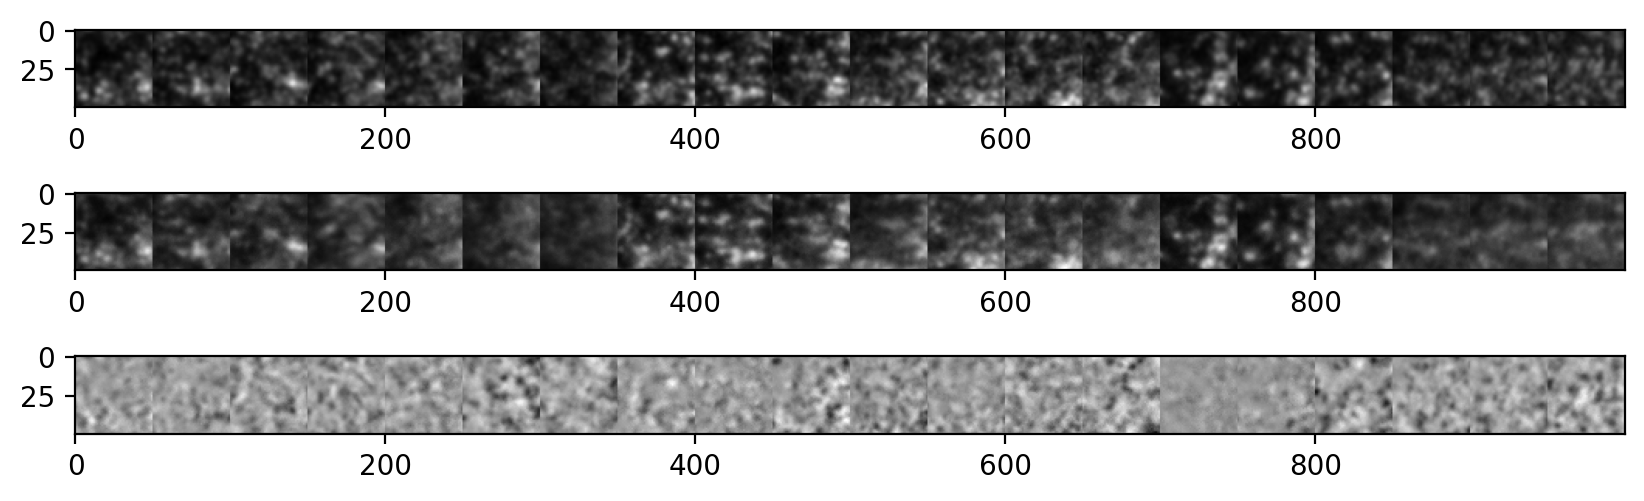

In [28]:
fig,ax=plt.subplots(3,1,figsize=(10, 3), dpi=200)
ax[0].imshow(display_image_input[4,:,:],  cmap='gray')
ax[1].imshow(display_image_output[4,:,:],  cmap='gray')
ax[2].imshow(display_image_output[4,:,:]-display_image_input[4,:,:],  cmap='gray')

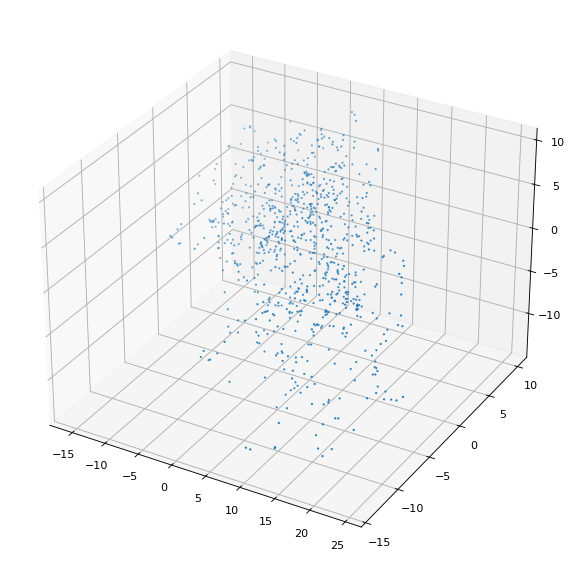

In [29]:

fig = plt.figure(figsize=(9,9), dpi=80)


if latent_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(
        Z_array[:, 0],
        Z_array[:, 1])
else:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        Z_array[:, 0],
        Z_array[:, 1],
        Z_array[:, 2],s=1)
    
fig.savefig("ACTO_xyz3D_results/"+model_ID+"_flow_distribution.png")

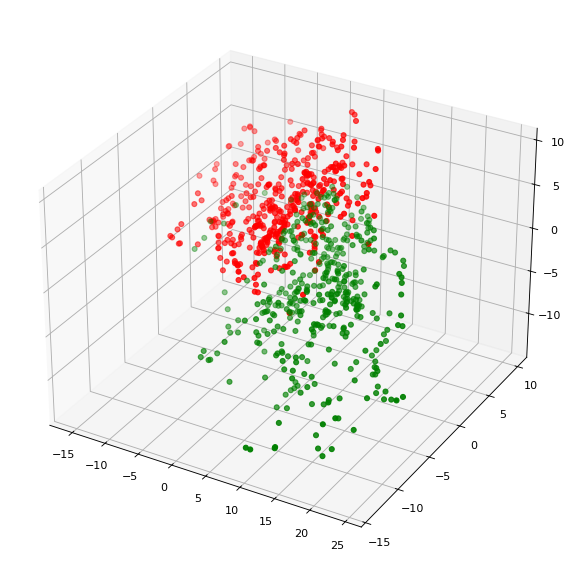

In [30]:
fig = plt.figure(figsize=(9,9), dpi=80)


if latent_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(
        Z_array[:, 0],
        Z_array[:, 1])
else:
    ax = fig.add_subplot(projection='3d')
    # ax.scatter(
    #     Z_array[0:140, 0],
    #     Z_array[0:140, 1],
    #     Z_array[0:140, 2],c='red')    
    # ax.scatter(
    #     Z_array[140:280, 0],
    #     Z_array[140:280, 1],
    #     Z_array[140:280, 2],c='green')    
    # ax.scatter(
    #     Z_array[280:420, 0],
    #     Z_array[280:420, 1],
    #     Z_array[280:420, 2],c='blue')
    ax.scatter(
        Z_array[0:420, 0],
        Z_array[0:420, 1],
        Z_array[0:420, 2],c='red')    
    ax.scatter(
        Z_array[420:840, 0],
        Z_array[420:840, 1],
        Z_array[420:840, 2],c='green')    
    
fig.savefig("ACTO_xyz3D_results/"+model_ID+"_flow_distribution.png")

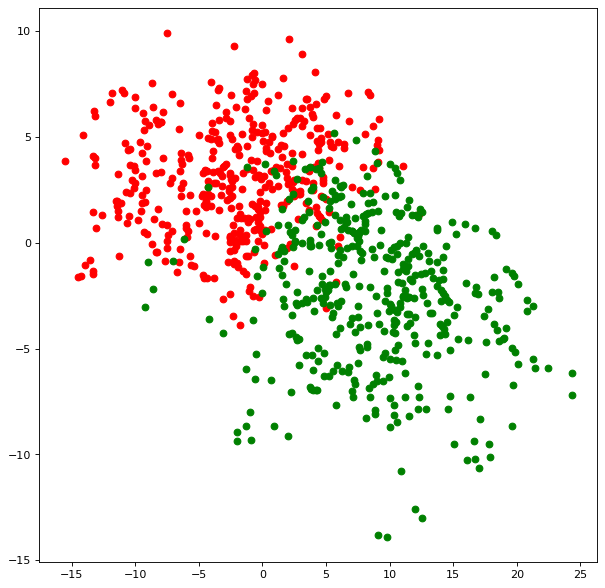

In [31]:
fig = plt.figure(figsize=(9,9), dpi=80)



ax = fig.add_subplot()
ax.scatter(
    Z_array[0:420, 0],
    Z_array[0:420, 1],c='red')    
ax.scatter(
    Z_array[420:840, 0],
    Z_array[420:840, 1],c='green')  

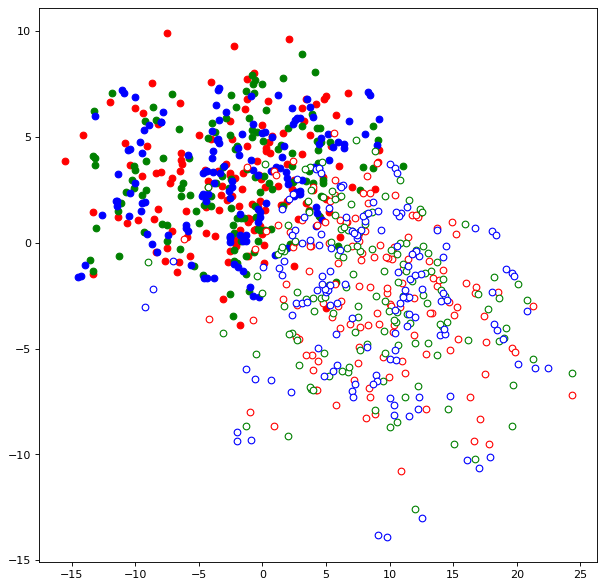

In [44]:
fig = plt.figure(figsize=(9,9), dpi=80)



ax = fig.add_subplot()
ax.scatter(
    Z_array[0:140, 0],
    Z_array[0:140, 1],c='red')    
ax.scatter(
    Z_array[140:280, 0],
    Z_array[140:280, 1],c='green')    
ax.scatter(
    Z_array[280:420, 0],
    Z_array[280:420, 1],c='blue')

ax.scatter(
    Z_array[420+0:420+140, 0],
    Z_array[420+0:420+140, 1],c='white',marker='o',edgecolors='red')  
ax.scatter(
    Z_array[420+140:420+280, 0],
    Z_array[420+140:420+280, 1],c='white',marker='o',edgecolors='green')  
ax.scatter(
    Z_array[420+280:420+420, 0],
    Z_array[420+280:420+420, 1],c='white',marker='o',edgecolors='blue')

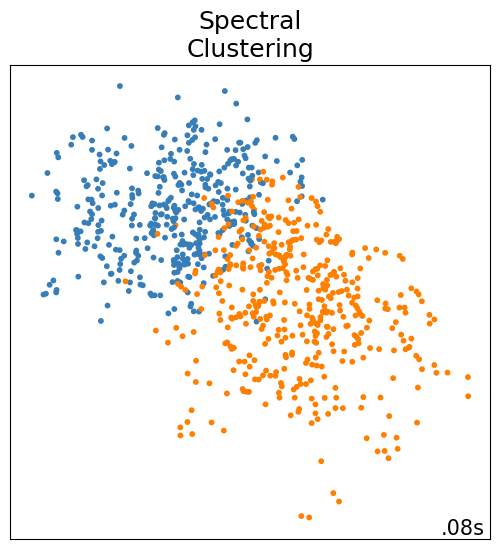

In [32]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
rng = np.random.RandomState(seed)
# Anisotropicly distributed data
random_state = 170
no_structure = rng.rand(n_samples, 2), None
# ============
# Set up cluster parameters
# ============
fig_clustering = plt.figure(figsize=(5, 5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 2,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    
    params = default_base.copy()
    params.update(algo_params)
   
    X = Z_array
    y = np.zeros(X.shape[0])

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    
    clustering_algorithms = (
        # ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        # ("MiniBatch\nKMeans", two_means),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)


        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

fig_clustering.savefig("results/"+model_ID+"_flow_clustering.png")

In [50]:
dec_dir = '/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/'

if not os.path.isdir(dec_dir):          
    os.mkdir(dec_dir)

now=datetime.now()
current_time = now.isoformat()[5:19]
print(current_time)


model_dec_dir = dec_dir+'decoded_results_'+ model_ID+'_' + current_time
model_org_dir = dec_dir+'orgin_imgs_'+ model_ID+'_' + current_time
analysis_dir = dec_dir+'analysis_results_'+ model_ID+'_' + current_time


if not os.path.isdir(model_dec_dir):          
    os.mkdir(model_dec_dir)

if not os.path.isdir(model_org_dir):          
    os.mkdir(model_org_dir)

if not os.path.isdir(analysis_dir):          
    os.mkdir(analysis_dir)



csv_output = pd.DataFrame(columns=['title', 'labelnumber','cluster_ID'])
for x_input, y_input in train_dataset:
    z = model.encode(x_input)
    x_output = model.decode(z).numpy().reshape([len(y_input),8, 50, 50])
    
    # y_pred = algorithm.predict(z.numpy())
    for i in range(z.numpy().shape[0]):
        input_label = y_input[i].numpy()
        input_img = x_input[i,:,:,:,0].numpy().squeeze()
        output_img = x_output[i,:,:,:]
        label_str = str(int(input_label)).zfill(12)
        ind = np.where(Label_array == input_label)        
        pred_ID = y_pred[ind[0][0]]        
        
        title = 'decoded'+label_str+'.tif'
        
        tifffile.imwrite(os.path.join(model_dec_dir,'dec_'+title), output_img)
       
        title = 'orgin'+label_str+'.tif'
        
        tifffile.imwrite(os.path.join(model_org_dir,'org_'+title), input_img)
        
        s = pd.DataFrame([[title, input_label,pred_ID]], columns=['title', 'labelnumber','cluster_ID'])
        csv_output = pd.concat([csv_output, s], ignore_index=True, axis=0)
        


csv_output.to_csv(os.path.join(analysis_dir,model_ID+'_clustering.csv'))
                           
        
       

08-11T16:31:38


/tmp/ipykernel_1432263/1810431505.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  csv_output = pd.concat([csv_output, s], ignore_index=True, axis=0)


In [61]:
x_input[0:2,:,:,:,:]

<tf.Tensor: shape=(2, 8, 50, 50, 1), dtype=float32, numpy=
array([[[[[0.09561753],
          [0.10956176],
          [0.1374502 ],
          ...,
          [0.17529881],
          [0.22111554],
          [0.25099602]],

         [[0.10159363],
          [0.11354582],
          [0.13346614],
          ...,
          [0.21115538],
          [0.23505977],
          [0.24900399]],

         [[0.0996016 ],
          [0.10756972],
          [0.12350598],
          ...,
          [0.24103586],
          [0.2549801 ],
          [0.26494023]],

         ...,

         [[0.39641434],
          [0.4243028 ],
          [0.39243028],
          ...,
          [0.18525897],
          [0.13147411],
          [0.09163347]],

         [[0.33665338],
          [0.38047808],
          [0.3565737 ],
          ...,
          [0.1932271 ],
          [0.1374502 ],
          [0.09760956]],

         [[0.25298804],
          [0.29681274],
          [0.29482073],
          ...,
          [0.17928287],
          

In [69]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv3D, Flatten, Dense, Conv3DTranspose, Reshape
for x_input, y_input in train_dataset:
    y = Conv3D(filters=8, kernel_size=3, strides=(2, 2, 2), activation='relu')(x_input[0:2,:,:,:,:])
    print(x_input[0:2,:,:,:,:].shape)
    print(y.shape)
    y = Conv3D(filters=16, kernel_size=[3,3,3], strides=(1, 2, 2), activation='relu')(y)
    print(y.shape)
    y = Conv3D(filters=32, kernel_size=[1,3,3], strides=(1, 2, 2), activation='relu')(y)
    print(y.shape)
    


(2, 8, 50, 50, 1)
(2, 3, 24, 24, 8)
(2, 1, 11, 11, 16)
(2, 1, 5, 5, 32)


In [35]:
label_str

'000000120063'

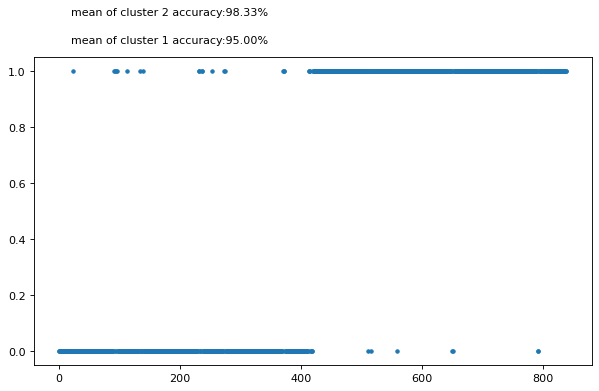

In [70]:
cluster_algorithm = csv_output['cluster_ID']
fig = plt.figure(figsize=(9,5), dpi=80)
plt.plot(csv_output['cluster_ID'],'.')

c1_accu = float(np.mean(cluster_algorithm.to_numpy()[0:420]))
c1_accu = 100 - c1_accu*100
plt.text(20,1.1,"mean of cluster 1 accuracy:" + ("%.2f" % c1_accu )+ "%")

c2_accu = float(np.mean(cluster_algorithm.to_numpy()[420:]))
c2_accu = c2_accu*100
plt.text(20,1.2,"mean of cluster 2 accuracy:" + ("%.2f" % c2_accu )+ "%")
 
fig.savefig("results/"+model_ID+"_flow_clustering.png")
 

(array([[399.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  21.],
        [  7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 413.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

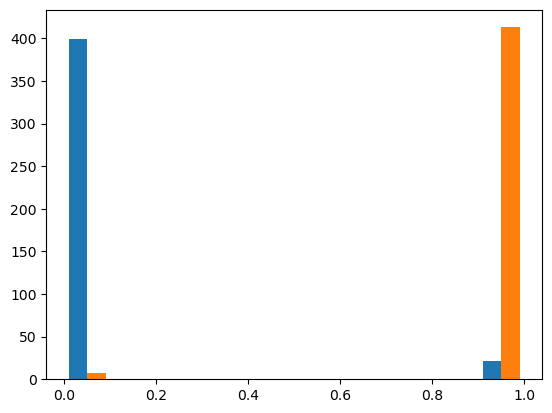

In [85]:
groups = np.zeros([420,2])
groups[:,0] = cluster_algorithm.to_numpy()[:420]
groups[:,1] = cluster_algorithm.to_numpy()[420:]


plt.hist(groups)

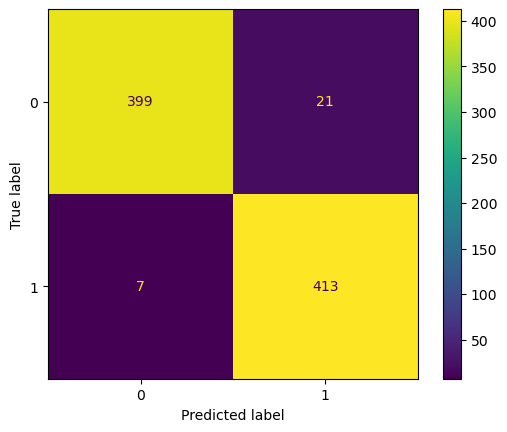

In [111]:
import sklearn
label_direction = np.zeros([1,840])
label_direction[0][420:]=1

disp = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(label_direction[0]>0,cluster_algorithm.to_numpy()>0))
disp.plot()
plt.show()

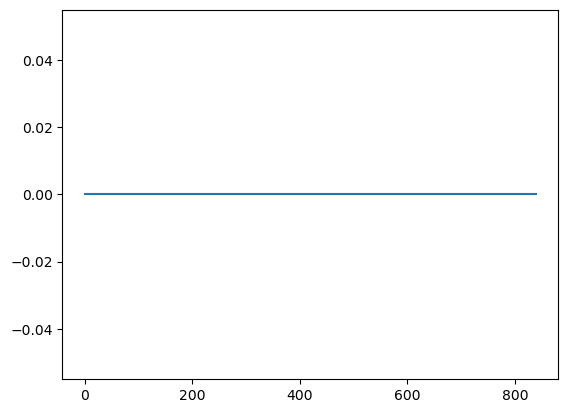

In [107]:
plt.plot(label_direction[0])

In [104]:
cluster_algorithm.to_numpy().shape


(840,)

In [37]:
cluster_algorithm

0      0
1      0
2      0
3      0
4      0
      ..
835    1
836    1
837    1
838    1
839    1
Name: cluster_ID, Length: 840, dtype: object

In [38]:
if latent_dim == 2:
    z0_max = np.percentile(Z_array[:,0], 99)
    z0_min = np.percentile(Z_array[:,0], 1)
    z1_max = np.percentile(Z_array[:,1], 99)
    z1_min = np.percentile(Z_array[:,1], 1)


    nxy = 10
    x = np.linspace(z0_min, z0_max,nxy)
    y = np.linspace(z1_min, z1_max,nxy)
    xv, yv = np.meshgrid(x, y)

    # plt.scatter(xv,yv)

    zv = np.concatenate((xv.reshape([nxy*nxy,1]),yv.reshape([nxy*nxy,1])), axis=1)

    x_output_manifold = model.decode(zv).numpy().reshape([nxy,nxy, 8,32,32])


    fig_manifold, axarr = plt.subplots(nxy, nxy, figsize=(nxy, nxy))
    for i in range(nxy):
        for j in range(nxy):    
            axarr[i, j].axis('off')
            axarr[i, j].imshow(x_output_manifold[i,j,4,:,:],cmap=plt.cm.gray)
            
        
    fig_manifold.savefig("results/"+model_ID+"_manifold.png")